# SWB Trend Prediction

***Purpose***

- (1) 삶의 만족도가 증가하는 시점, 감소하는 시점 파악
- (2) 삶의 만족도가 증가할 때의 사용자 행동 패턴 파악
- (3) 삶의 만족도가 감소하는 시점에(1), 삶의 만족도가 증가할 때의 사용자 패턴을 추천(2) 

***undoing effect***
- 긍정적 정서가 부정적 정서의 영향 이후에 균형감, 유연성, 그리고 평정상태의 회복을 도와 불행한 효과를 빨리 사라지게 한다는 취소 효과(undoing effect)
****

- X (***all features are normalized for each user***)
    - Smartphone Features
        1. Activity
        2. App Usage
        3. Loc
        4. Sleep
    - Pre Survey 
    

- Y 
    - SWB Trend Prediction  :  전반적인 삶의 만족도 (COMOSWB) 점수를 기반으로 3일에 한번 측정한 값을 사용
        1. Increase : 이전 측정값에 비해 삶의 만족도가 증가한 경우
        2. Decrease : 이전 측정값에 비해 삶의 만족도가 감소한 경우
        3. No change : 이전 측정값과 동일한 경우



In [73]:
from IPython.display import Image

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


import shap

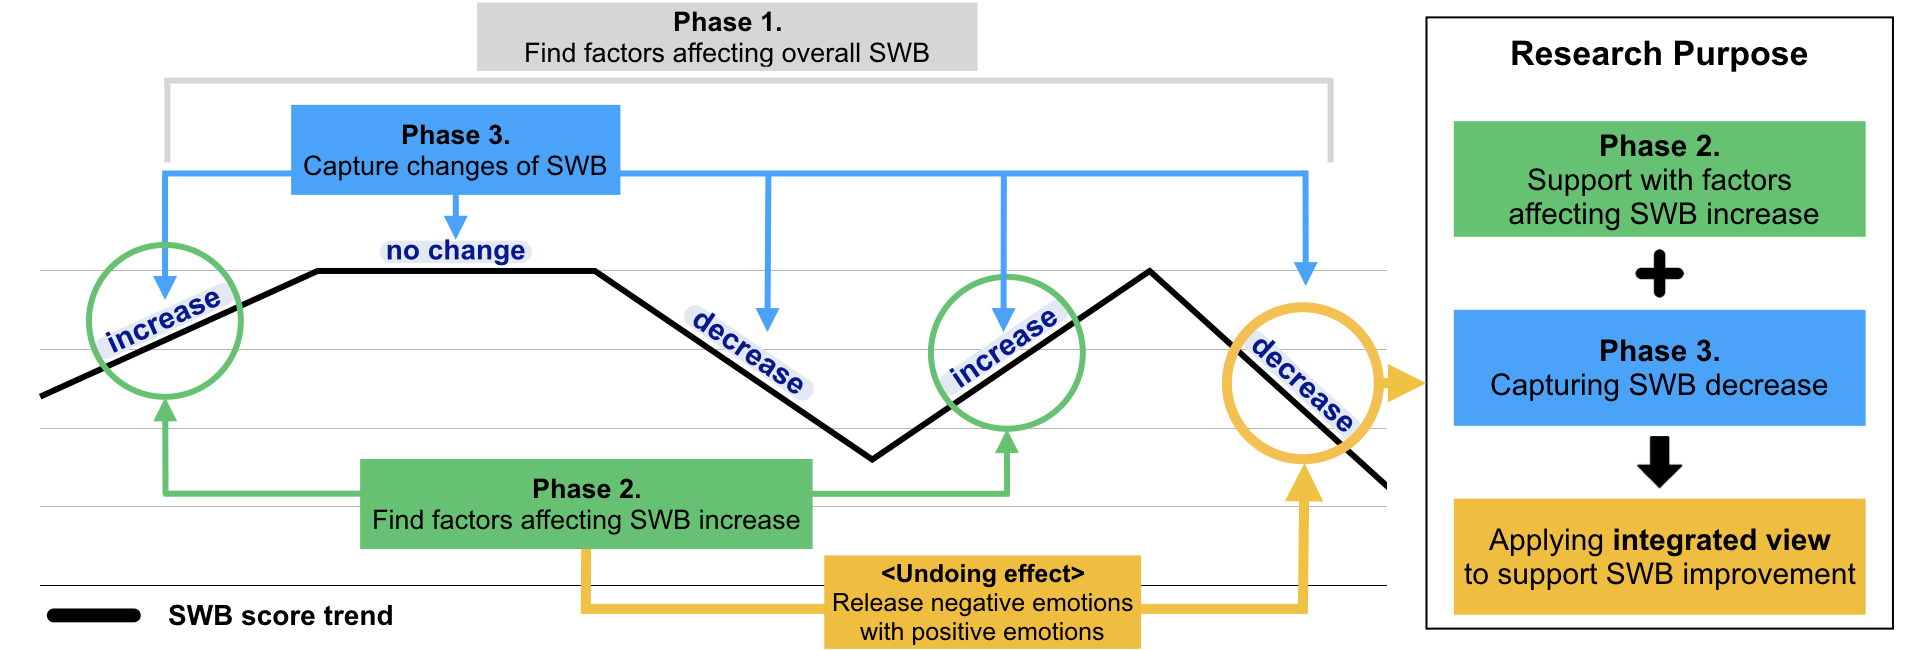

In [4]:
Image("../../img/DP_SWB_change.jpeg") 

# Features

In [8]:
swb = pd.read_csv('../../Sample_Data/Final/SWB_final.csv')
swb.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,...,sleep_duration,sleep_onset_abs,wake_up_abs,dayofWeek,SWB_score,label_3,POS,NEG,SAT,Measured
0,0,0,2017.9.10,20946596,0,1,1.0,39,23,10,...,0.399396,0.140638,0.317838,6,21.0,0,16,13,18,1
1,1,1,2017.9.11,20946596,0,1,1.0,39,23,10,...,0.613690,0.056220,0.340805,0,21.0,0,16,13,18,0
2,2,2,2017.9.12,20946596,0,1,1.0,39,23,10,...,0.571840,0.049202,0.311964,1,21.0,0,16,13,18,0
3,3,3,2017.9.13,20946596,0,1,1.0,39,23,10,...,0.658228,0.111161,0.420694,2,21.0,0,16,13,18,0
4,4,4,2017.9.14,20946596,0,1,1.0,39,23,10,...,0.332802,0.245503,0.392184,3,21.0,1,16,11,16,1


## Presurvey

1. 스트레스 - PSS
2. 운동기능 - EQ-5D-5L
3. 행복 - COMOSWB
4. 자아존중감 - RSE  
5. 우울 - PHQ 
6. 삶의 만족 - SWLS
7. 긍정심리자본 - PPC
8. 스마트폰 중독 - SAS
9. 성격 5 요인 - BFI

In [19]:
swb_survey = swb.iloc[:, 2:30]
swb_survey.head()

,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,BFI_CON,BFI_NEU,...,RSE,PPC_HOP,PPC_OPT,PPC_RES,PPC_SEL,EQ_MOB,EQ_PAI,EQ_SEL,EQ_USU,PSS
0,2017.9.10,20946596,0,1,1.0,39,23,10,11,8,...,4.5,19.25,28.0,14.0,19.75,1,1,1,1,-2
1,2017.9.11,20946596,0,1,1.0,39,23,10,11,8,...,4.5,19.25,28.0,14.0,19.75,1,1,1,1,-2
2,2017.9.12,20946596,0,1,1.0,39,23,10,11,8,...,4.5,19.25,28.0,14.0,19.75,1,1,1,1,-2
3,2017.9.13,20946596,0,1,1.0,39,23,10,11,8,...,4.5,19.25,28.0,14.0,19.75,1,1,1,1,-2
4,2017.9.14,20946596,0,1,1.0,39,23,10,11,8,...,4.5,19.25,28.0,14.0,19.75,1,1,1,1,-2


## Loc

- 0, 1, 2, ...10 : 위치정보(GPS) 를 GMM Clustering 하여 각 위치 군집에 학생이 머무른 시간 계산
- distance : 일별 총 이동거리
- move_cnt : 군집화된 위치 정보를 기반으로, 일별 군집간 이동 수 계산

In [23]:
swb_loc = swb.iloc[:, 30:43]
swb_loc.head()

,0,1,10,2,3,4,5,6,7,8,9,distance,move_cnt
0,0.0,0.000000,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636364,0.307988,0.05
1,0.0,0.010137,0.994555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.041406,0.20
2,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.090053,0.00
3,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.054847,0.00
4,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022812,0.00


## App Usage

- App sum : 일별 핸드폰 사용량
- 일별 각 카테고리 사용량 :  각 카테고리는 google play store 크롤링 기준
- morning screenOn, evening screenOn, afternoon screenOn : 시간대별 Screen on duration


In [31]:
swb_app = swb.iloc[:, 43:62]
swb_app.head()

,App_sum,Art&Design&Photo,Bank&Purchase,Books & Reference,Educational,Entertainment&Music,Food & Drink,Games&Comics,Health&Well,News & Magazines,Others,Shopping,Social&Communication,Travel,Utilities,Weather,afternoon screenOn,evening screenOn,morning screenOn
0,0.654676,0.0,0.047586,0.051020,0.0,0.321606,1.00000,0.181319,0.0,0.0,0.000000,0.837912,0.829670,0.0,0.363736,0.0,0.652381,0.134529,0.129310
1,0.812950,0.0,0.007664,0.193697,0.0,0.136312,0.14642,0.476991,0.0,0.0,0.000000,0.000000,0.776549,0.0,0.439381,0.0,0.466667,0.470852,0.362069
2,0.501799,0.0,0.124168,0.389876,0.0,0.000000,0.00000,0.094624,0.0,0.0,0.182796,0.000000,0.792115,0.0,0.000000,0.0,0.328571,0.381166,0.206897
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.647619,0.479821,0.353448
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.509524,0.197309,0.172414


## Activity

***Still : Google Fit API 이용***

- ratio_still (morning, afternoon, evening) : 각 시간대별 움직임이 없는 시간의 비율
- still_total_all : 하룻동안 움직임이 없었던 시간

In [34]:
swb_act = swb.iloc[:, 62:66]
swb_act.head()

,ratio_still_afternoon,ratio_still_evening,ratio_still_morning,still_total_all
0,0.421557,0.480348,0.787500,0.555189
1,0.660395,0.277206,0.814350,0.630972
2,0.653123,0.379668,0.732398,0.703460
3,0.713731,0.273192,0.785498,0.639209
4,0.539001,0.380409,0.800743,0.691928


## Sleep & Day

- sleep_duration : 일별 수면시간
- sleep_onset_abs : 잠든 시각
- wake_up_abs : 일어난 시각

- dayofWeek : 요일

In [39]:
swb_sleep_day = swb.iloc[:, 66:70]
swb_sleep_day.head()

,sleep_duration,sleep_onset_abs,wake_up_abs,dayofWeek
0,0.399396,0.140638,0.317838,6
1,0.613690,0.056220,0.340805,0
2,0.571840,0.049202,0.311964,1
3,0.658228,0.111161,0.420694,2
4,0.332802,0.245503,0.392184,3


## Others

- SWB_score : POS + SAT - NEG
- label_3 : y labeling (3class)
- POS, NEG, SAT : COMOSWB 측정 요소
- Measures : 측정한 날 체크
(3일에 한번 측정했기 때문에 데이터의 양을 늘리기 위해 SWB 값을 linear 하게 가정)

# Classification

- Randomforest
- LogisticRegression
- AdaBoost

In [43]:
swb.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,...,sleep_duration,sleep_onset_abs,wake_up_abs,dayofWeek,SWB_score,label_3,POS,NEG,SAT,Measured
0,0,0,2017.9.10,20946596,0,1,1.0,39,23,10,...,0.399396,0.140638,0.317838,6,21.0,0,16,13,18,1
1,1,1,2017.9.11,20946596,0,1,1.0,39,23,10,...,0.613690,0.056220,0.340805,0,21.0,0,16,13,18,0
2,2,2,2017.9.12,20946596,0,1,1.0,39,23,10,...,0.571840,0.049202,0.311964,1,21.0,0,16,13,18,0
3,3,3,2017.9.13,20946596,0,1,1.0,39,23,10,...,0.658228,0.111161,0.420694,2,21.0,0,16,13,18,0
4,4,4,2017.9.14,20946596,0,1,1.0,39,23,10,...,0.332802,0.245503,0.392184,3,21.0,1,16,11,16,1


In [52]:
def classification(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

    pipelines = []

    pipelines.append(('RF', Pipeline([('RF',RandomForestClassifier())])))
    pipelines.append(('LR', Pipeline([('LR',LogisticRegression() )])))
    pipelines.append(('AB', Pipeline([('AB', AdaBoostClassifier(n_estimators=50,
                             learning_rate=1))])))


    results = []
    names = []
    tmp_df = pd.DataFrame(columns = ['model', 'accuracy', 'f1_micro', 'f1_macro'])
    
    for name, model in pipelines:
        kfold = KFold(n_splits=10)
        scoring = {'accuracy': 'accuracy',
           'f1_micro': 'f1_micro',
           'f1_macro': 'f1_macro'}
        
        cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)

        results.append(cv_results)
        names.append(name)
        tmp_df = tmp_df.append({'model': name,'accuracy': cv_results['test_accuracy'].mean().mean(),
                               'f1_micro':cv_results['test_f1_micro'].mean().mean(),
                               'f1_macro': cv_results['test_f1_macro'].mean().mean()
                               }, ignore_index = True)
        

    return tmp_df

def getClassResult(normalized_df, allFeatures, ylabel):

    ### 모든 유저의 모델 성능
    class_all = pd.DataFrame()
    
    X = normalized_df[allFeatures].values
    Y = normalized_df[ylabel].values
    class_all = classification(X, Y)

    ### 각 유저별 모델 성능
    class_each = pd.DataFrame()
    count = 0
    for user in set(normalized_df['uid']):
        count +=1
        print("{:.2f}".format(float(count)/len(set(normalized_df['uid']))*100), end = '\r')
        tmp = normalized_df[normalized_df['uid'] == user]
        X = tmp[allFeatures].values
        Y = tmp[ylabel].values
        tmp_each = classification(X, Y)
        tmp_each['uid'] = user
        class_each = pd.concat([class_each.reset_index(drop=True), tmp_each.reset_index(drop=True)])
    
    
    return  class_all, class_each

## Classification without Presurvey

In [70]:
user_info = ['uid', 'gender', 'group']
loc = ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9','distance', 'move_cnt']
act = ['ratio_still_afternoon', 'ratio_still_evening', 'ratio_still_morning','still_total_all']
app = ['App_sum', 'Art&Design&Photo', 'Bank&Purchase',
       'Books & Reference', 'Educational', 'Entertainment&Music',
       'Food & Drink', 'Games&Comics', 'News & Magazines',
       'Others', 'Shopping', 'Social&Communication', 'Travel', 'Utilities',
       'Weather', 
         'afternoon screenOn', 'evening screenOn', 'morning screenOn']
sleep_day = ['sleep_duration', 'sleep_onset_abs', 'still_total_all', 
         'wake_up_abs','dayofWeek']

features = user_info[1:] + loc + act + app + sleep_day



In [ ]:
class_all, class_each = getClassResult(swb, features, 'label_3')

In [54]:
class_all

,model,accuracy,f1_micro,f1_macro
0,RF,0.476878,0.476878,0.350069
1,LR,0.466232,0.466232,0.334741
2,AB,0.463243,0.463243,0.352109


In [57]:
class_each.sort_values(by='f1_micro', ascending=False)

,model,accuracy,f1_micro,f1_macro,uid
126,RF,0.960714,0.960714,0.839487,46029500
127,LR,0.960714,0.960714,0.839487,46029500
128,AB,0.923214,0.923214,0.729011,46029500
99,RF,0.710714,0.710714,0.620310,22955826
101,AB,0.669643,0.669643,0.607215,22955826
...,...,...,...,...,...
152,AB,0.337500,0.337500,0.275794,41860680
229,LR,0.319643,0.319643,0.263042,41651454
220,LR,0.314286,0.314286,0.217937,93542520
224,AB,0.308929,0.308929,0.219935,47043065


## Model 해석 (SHAP)

- sample user 의 모델 예측 결과 분석
- best case : 46029500 (***No change 에 편향된 데이터***)
- worst case : 93542520 


In [64]:
import collections

sample1 = swb[swb['uid'] == 46029500]
print(sample1.shape, collections.Counter(sample1['label_3']))


sample2 = swb[swb['uid'] == 93542520]
print(sample2.shape, collections.Counter(sample2['label_3']))


(98, 76) Counter({0: 94, 1: 4})
(88, 76) Counter({1: 39, -1: 31, 0: 18})


### Sample1

In [68]:
sample1.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,gender,group,PPC,SAS,SWLS,BFI_EXT,...,sleep_duration,sleep_onset_abs,wake_up_abs,dayofWeek,SWB_score,label_3,POS,NEG,SAT,Measured
2690,2690,2690,2017.9.10,46029500,0,0,1.0,17,18,9,...,0.152352,0.300795,0.377540,6,6.0,1,10,15,11,1
2691,2691,2691,2017.9.11,46029500,0,0,1.0,17,18,9,...,0.662427,0.011696,0.374900,0,7.5,1,10,15,11,0
2692,2692,2692,2017.9.12,46029500,0,0,1.0,17,18,9,...,0.631540,0.004850,0.348801,1,9.0,1,10,15,11,0
2693,2693,2693,2017.9.13,46029500,0,0,1.0,17,18,9,...,0.650122,0.013413,0.369295,2,10.5,1,10,15,11,0
2694,2694,2694,2017.9.14,46029500,0,0,1.0,17,18,9,...,0.750692,0.961536,0.371609,3,12.0,0,12,12,12,1


In [72]:
X = sample1[features]
y = sample1['label_3'].values

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.20, random_state=42)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=100)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)


print('정확도 : ', metrics.accuracy_score(Y_test, y_pred))

print('f1-score macro: ', metrics.f1_score(Y_test, y_pred, average='macro'))

print('f1-score micro: ', metrics.f1_score(Y_test, y_pred, average='micro'))

print('f1-score weighted: ', metrics.f1_score(Y_test, y_pred, average='weighted'))


정확도 :  0.95
f1-score macro:  0.48717948717948717
f1-score micro:  0.9500000000000001
f1-score weighted:  0.9256410256410256


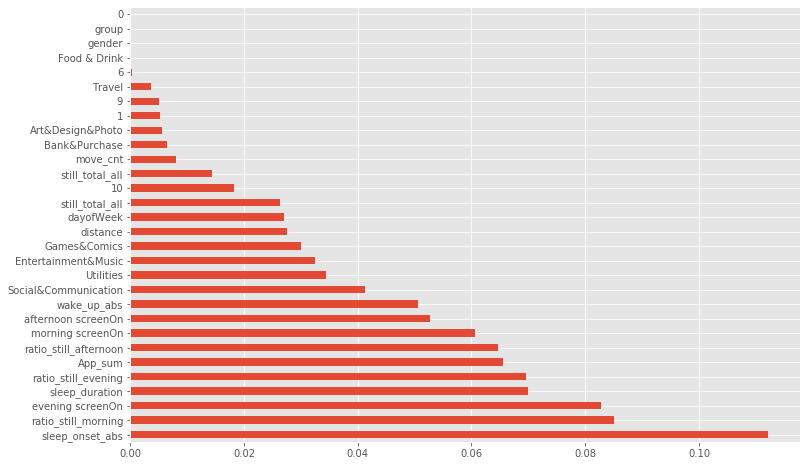

In [74]:
plt.figure(figsize=(12,8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')  


In [81]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
explainer.feature_perturbation = "tree_path_dependent"

# print(X_test.iloc[10,:])
print(set(y), Y_test[10])

shap_values = explainer.shap_values(X_test.iloc[10,:])
# print(shap_values, explainer.expected_value)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[10,:])

{0, 1} 0


### Sample2

In [82]:
X = sample2[features]
y = sample2['label_3'].values

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.20, random_state=42)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=100)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)


print('정확도 : ', metrics.accuracy_score(Y_test, y_pred))

print('f1-score macro: ', metrics.f1_score(Y_test, y_pred, average='macro'))

print('f1-score micro: ', metrics.f1_score(Y_test, y_pred, average='micro'))

print('f1-score weighted: ', metrics.f1_score(Y_test, y_pred, average='weighted'))


정확도 :  0.5
f1-score macro:  0.43909774436090226
f1-score micro:  0.5
f1-score weighted:  0.5030910609857978


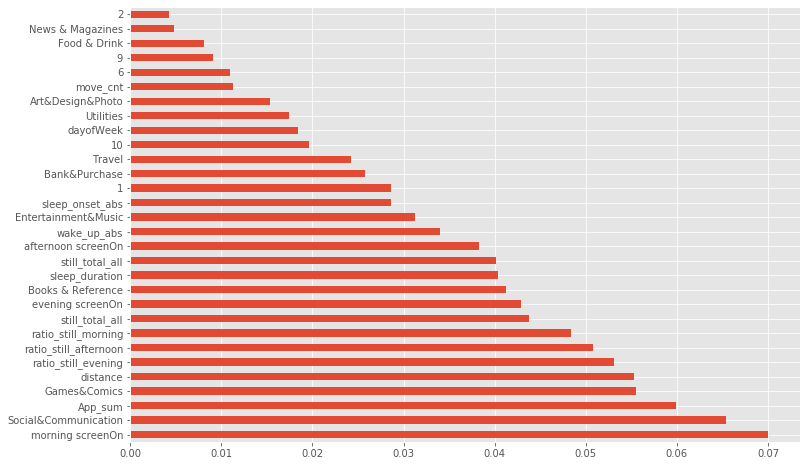

In [83]:
plt.figure(figsize=(12,8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')  


In [86]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
explainer.feature_perturbation = "tree_path_dependent"

# print(X_test.iloc[10,:])
print(set(y), Y_test[10])

shap_values = explainer.shap_values(X_test.iloc[10,:])
# print(shap_values, explainer.expected_value)
shap.force_plot(explainer.expected_value[2], shap_values[2], X_test.iloc[10,:])

{0, 1, -1} -1
